# EDA 구상안

기본 분포 파악: 전체 거래가 어떤 모양인지(시간/금액/채널/업종/오류)

Fraud와의 차이 확인: fraud=1과 fraud=0에서 무엇이 달라지는지(리프트/비율 차이)

고객(카드) 행동 관점 설명: “평소 대비 급변(z-score/ratio)” 지표가 왜 유효한지 숫자로 보여주기







In [ ]:
import os, glob
import duckdb
import pandas as pd
from IPython.display import display

# 0-1) DuckDB 연결: analysis.duckdb가 있으면 그걸 우선 사용(테이블이 이미 있을 수 있음)
DB_PATH = "analysis.duckdb"
con = duckdb.connect(DB_PATH) if os.path.exists(DB_PATH) else duckdb.connect()

# 성능(선택)
con.execute("PRAGMA threads=4;")  # 코랩 코어에 맞게 조정 가능(예: 2~8)

# 0-2) 거래 데이터 소스 자동 선택
# 우선순위: (1) duckdb 내부 테이블 transactions_base 존재 -> (2) transactions_base_full.parquet -> (3) part parquet glob
tables = set(con.execute("SHOW TABLES").fetchdf()["name"].tolist()) if os.path.exists(DB_PATH) else set()

FULL_PARQUET = "transactions_base_full.parquet"
PART_GLOB = "transactions_base_part_*.parquet"

if "transactions_base" in tables:
    con.execute("CREATE OR REPLACE VIEW v_tx AS SELECT * FROM transactions_base;")
    TX_SOURCE = "duckdb:transactions_base"
elif os.path.exists(FULL_PARQUET):
    con.execute(f"CREATE OR REPLACE VIEW v_tx AS SELECT * FROM read_parquet('{FULL_PARQUET}');")
    TX_SOURCE = FULL_PARQUET
elif len(glob.glob(PART_GLOB)) > 0:
    con.execute(f"CREATE OR REPLACE VIEW v_tx AS SELECT * FROM read_parquet('{PART_GLOB}');")
    TX_SOURCE = PART_GLOB
else:
    raise FileNotFoundError("거래 데이터 소스를 찾지 못했습니다. transactions_base_full.parquet 또는 transactions_base_part_*.parquet 또는 analysis.duckdb가 필요합니다.")

print(f"[OK] 거래 데이터 소스: {TX_SOURCE}")

# 0-3) 카드/유저 common이 있으면 view로 올려두기(선택)
if os.path.exists("card_common.csv"):
    con.execute("CREATE OR REPLACE VIEW v_card AS SELECT * FROM read_csv_auto('card_common.csv');")
    print("[OK] v_card 생성(card_common.csv)")

if os.path.exists("user_common.csv"):
    con.execute("CREATE OR REPLACE VIEW v_user AS SELECT * FROM read_csv_auto('user_common.csv');")
    print("[OK] v_user 생성(user_common.csv)")

# 0-4) 카드 로그 결과물이 있으면 view로 올려두기(선택)
if "card_daily_features" in tables:
    con.execute("CREATE OR REPLACE VIEW v_cdf AS SELECT * FROM card_daily_features;")
    print("[OK] v_cdf 생성(duckdb:card_daily_features)")
elif os.path.exists("card_daily_features.parquet"):
    con.execute("CREATE OR REPLACE VIEW v_cdf AS SELECT * FROM read_parquet('card_daily_features.parquet');")
    print("[OK] v_cdf 생성(card_daily_features.parquet)")

if "card_daily_log" in tables:
    con.execute("CREATE OR REPLACE VIEW v_cdl AS SELECT * FROM card_daily_log;")
    print("[OK] v_cdl 생성(duckdb:card_daily_log)")
elif os.path.exists("card_daily_log.parquet"):
    con.execute("CREATE OR REPLACE VIEW v_cdl AS SELECT * FROM read_parquet('card_daily_log.parquet');")
    print("[OK] v_cdl 생성(card_daily_log.parquet)")

# 0-5) 컬럼 목록 확인(후속 셀에서 조건 분기용)
cols = set(con.execute("""
SELECT column_name
FROM information_schema.columns
WHERE table_name='v_tx'
""").fetchdf()["column_name"].tolist())

print("[v_tx columns sample]", sorted(list(cols))[:25])
print("[v_tx columns count]", len(cols))

# 빠른 row check
display(con.execute("SELECT COUNT(*) AS n_rows FROM v_tx").fetchdf())

[OK] 거래 데이터 소스: duckdb:transactions_base
[OK] v_card 생성(card_common.csv)
[OK] v_user 생성(user_common.csv)
[OK] v_cdf 생성(duckdb:card_daily_features)
[OK] v_cdl 생성(duckdb:card_daily_log)
[v_tx columns sample] ['amount_num', 'card_id', 'client_id', 'date', 'error_group', 'error_raw', 'fraud', 'has_error', 'id', 'is_online', 'mcc', 'merchant_city', 'merchant_id', 'merchant_state', 'use_chip', 'zip']
[v_tx columns count] 16


,n_rows
0,8914963


# 1) EDA에서 사용할 “최종 데이터” 선택

EDA는 모집단/정의가 바뀌면 결론이 흔들리니까, 시작 전에 베이스를 하나로 고정해야 해.

옵션 A(추천): 전수 기준선

transactions_base_full.parquet (또는 analysis.duckdb의 transactions_base)

장점: 이번에 만든 가설 스크리닝/로그 분석 결과와 100% 일관

옵션 B: common 기반(교집합)

common/trans_common.csv + user_common.csv + card_common.csv

장점: 팀이 익숙한 EDA 메인

단점: 교집합 서브셋이라 “전체 대표 수치”와 다를 수 있음 + 파생변수 정의(QC) 필요

권장 룰:

“이번 결과물(로그/가설)과 일관성 유지”가 목적이면 옵션 A로 고정

# 2) QC 게이트

여기서 걸리면 EDA를 멈추고 정의/타입을 고쳐야 함.
(이 단계가 EDA 전체의 신뢰도를 좌우함)

Gate 체크리스트(최소 6개)

행 수 / 기간

COUNT(*), MIN(date), MAX(date)

id 유니크

id 중복 여부

fraud 라벨 정상

0/1인지, fraud rate가 말이 되는 수준인지

is_online 정상성

is_online 분포(0/1이 모두 존재?)

use_chip == Online Transaction과의 일치율(가능하면)

amount_num 정상성

파싱 실패/결측 비율

음수(환불) 비중 확인

error_group / has_error 정상성

값 분포가 상식적인지(NO_ERROR가 대부분인지 등)

Gate 통과 기준(예시)

행 수가 기대한 규모와 일치(전수면 8.9M 수준)

is_online이 상수(전부 0 또는 전부 1)가 아님

fraud가 0/1로만 구성

amount_num 결측이 과도하지 않음(파싱 실패 신호)

In [ ]:
def q(sql: str):
    df = con.execute(sql).fetchdf()
    display(df)
    return df

print("1) 행수/기간/사기율")
q("""
SELECT
  COUNT(*) AS n_rows,
  MIN(CAST(date AS TIMESTAMP)) AS min_date,
  MAX(CAST(date AS TIMESTAMP)) AS max_date,
  AVG(CAST(fraud AS DOUBLE)) AS fraud_rate
FROM v_tx
""")

print("2) id 중복(있으면 위험)")
if "id" in cols:
    q("""
    SELECT
      COUNT(*) AS n_rows,
      COUNT(DISTINCT id) AS n_distinct_id,
      COUNT(*) - COUNT(DISTINCT id) AS dup_id_rows
    FROM v_tx
    """)
else:
    print(" - [SKIP] id 컬럼 없음")

print("3) 라벨 분포(0/1인지 확인)")
q("""
SELECT
  CAST(fraud AS INTEGER) AS fraud,
  COUNT(*) AS n
FROM v_tx
GROUP BY 1
ORDER BY 1
""")

print("4) is_online 분포 + use_chip 기반 온라인과의 불일치 점검(핵심 게이트)")
if "is_online" in cols and "use_chip" in cols:
    q("""
    SELECT
      CAST(is_online AS INTEGER) AS is_online,
      COUNT(*) AS n
    FROM v_tx
    GROUP BY 1
    ORDER BY 1
    """)
    q("""
    WITH x AS (
      SELECT
        CAST(is_online AS INTEGER) AS is_online,
        CASE WHEN use_chip='Online Transaction' THEN 1 ELSE 0 END AS online_by_use_chip
      FROM v_tx
    )
    SELECT
      AVG(CASE WHEN is_online=online_by_use_chip THEN 1.0 ELSE 0.0 END) AS match_rate,
      SUM(CASE WHEN is_online!=online_by_use_chip THEN 1 ELSE 0 END) AS mismatch_rows,
      COUNT(*) AS total_rows
    FROM x
    """)
else:
    print(" - [SKIP] is_online/use_chip 둘 중 하나 없음")

print("5) amount_num 결측/음수(환불 추정)/0 비율")
if "amount_num" in cols:
    q("""
    SELECT
      SUM(CASE WHEN amount_num IS NULL THEN 1 ELSE 0 END) AS null_amt,
      SUM(CASE WHEN amount_num < 0 THEN 1 ELSE 0 END) AS neg_amt,
      SUM(CASE WHEN amount_num = 0 THEN 1 ELSE 0 END) AS zero_amt,
      COUNT(*) AS n_rows
    FROM v_tx
    """)
else:
    print(" - [SKIP] amount_num 없음")

print("6) 오류 분포(has_error, error_group)")
if "has_error" in cols:
    q("""
    SELECT CAST(has_error AS INTEGER) AS has_error, COUNT(*) AS n
    FROM v_tx
    GROUP BY 1
    ORDER BY 1
    """)
if "error_group" in cols:
    q("""
    SELECT error_group, COUNT(*) AS n
    FROM v_tx
    GROUP BY 1
    ORDER BY n DESC
    LIMIT 20
    """)

print("7) Gate 경고(상수/불일치 자동 경고)")
# is_online 상수 경고
if "is_online" in cols:
    n_unique_online = con.execute("SELECT COUNT(DISTINCT CAST(is_online AS INTEGER)) FROM v_tx").fetchone()[0]
    if n_unique_online <= 1:
        print("⚠️ [WARN] is_online이 상수로 보입니다(0/1 중 하나만 존재). 정의/생성 로직 점검 필요.")
# use_chip 온라인이 있는데 is_online=0만 존재하는지
if "use_chip" in cols and "is_online" in cols:
    cnt_online_chip = con.execute("SELECT COUNT(*) FROM v_tx WHERE use_chip='Online Transaction'").fetchone()[0]
    cnt_online_flag = con.execute("SELECT COUNT(*) FROM v_tx WHERE CAST(is_online AS INTEGER)=1").fetchone()[0]
    if cnt_online_chip > 0 and cnt_online_flag == 0:
        print("⚠️ [WARN] use_chip에는 Online Transaction이 존재하지만 is_online=1이 0건입니다. is_online 정의를 use_chip 기준으로 재생성 권장.")


1) 행수/기간/사기율


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,n_rows,min_date,max_date,fraud_rate
0,8914963,2010-01-01 00:01:00,2019-10-31 23:57:00,0.001495


2) id 중복(있으면 위험)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,n_rows,n_distinct_id,dup_id_rows
0,8914963,8914963,0


3) 라벨 분포(0/1인지 확인)


,fraud,n
0,0,8901631
1,1,13332


4) is_online 분포 + use_chip 기반 온라인과의 불일치 점검(핵심 게이트)


,is_online,n
0,0,7870988
1,1,1043975


,match_rate,mismatch_rows,total_rows
0,1.0,0.0,8914963


5) amount_num 결측/음수(환불 추정)/0 비율


,null_amt,neg_amt,zero_amt,n_rows
0,0.0,442779.0,7193.0,8914963


6) 오류 분포(has_error, error_group)


,has_error,n
0,0,8773196
1,1,141767


,error_group,n
0,NO_ERROR,8773196
1,FUNDS,88012
2,AUTH_CREDENTIAL,34975
3,SYSTEM,18013
4,OTHER,767


7) Gate 경고(상수/불일치 자동 경고)


#QC Gate 결과 해석(이상 유무 판단)
전수/범위

행수: 8,914,963 → 전수 게이트 기준으로 정상

기간: 2010-01-01 ~ 2019-10-31 → 장기간 데이터로 정상

fraud_rate: 0.001495 → 약 0.1495% (약 1,000건 중 1.5건) 수준의 희귀 이벤트

키 무결성

id 중복: 0 → 분석/집계에서 “중복으로 사기율 부풀려지는 문제” 없음

is_online 정의(가장 중요했던 부분)

is_online=1 1,043,975건, 0 7,870,988건

use_chip 기반 온라인과의 일치율 match_rate=1.0, mismatch=0

amount_num 품질

결측(null_amt) 0

음수(환불 추정) 442,779건 → 전체의 약 4.97%

0원 7,193건 → 0.081% 정도

오류 분포

has_error=1 141,767건 → 전체의 약 1.59%

error_group 합이 has_error와 정확히 일치:

FUNDS 88,012 (약 0.987%)

AUTH_CREDENTIAL 34,975 (약 0.392%)

SYSTEM 18,013 (약 0.202%)

OTHER 767 (약 0.0086%)

# 3) 기본 분포

QC 통과 후, 전체 분포를 먼저 깔아야 다음 비교가 의미가 있어.

# 3-1) 거래량 분포

일자별 거래 수(타임라인)

요일별/시간대별 거래 수







In [ ]:
from IPython.display import display

def q(sql: str):
    df = con.execute(sql).fetchdf()
    display(df)
    return df

print("1) 일자별 거래량(초기 20일)")
q("""
SELECT
  DATE_TRUNC('day', CAST(date AS TIMESTAMP)) AS day,
  COUNT(*) AS tx_cnt
FROM v_tx
GROUP BY 1
ORDER BY day
LIMIT 20
""")

print("2) 요일별 거래량 (0=일, 1=월 ...)")
q("""
SELECT
  EXTRACT('dow' FROM CAST(date AS TIMESTAMP)) AS dow,
  COUNT(*) AS tx_cnt
FROM v_tx
GROUP BY 1
ORDER BY 1
""")

print("3) 시간대별 거래량")
q("""
SELECT
  EXTRACT('hour' FROM CAST(date AS TIMESTAMP)) AS hour,
  COUNT(*) AS tx_cnt
FROM v_tx
GROUP BY 1
ORDER BY 1
""")


1) 일자별 거래량(초기 20일)


,day,tx_cnt
0,2010-01-01,2329
1,2010-01-02,1971
2,2010-01-03,2201
3,2010-01-04,2216
4,2010-01-05,2269
5,2010-01-06,2318
6,2010-01-07,2303
7,2010-01-08,2056
8,2010-01-09,2065
9,2010-01-10,2253


2) 요일별 거래량 (0=일, 1=월 ...)


,dow,tx_cnt
0,0,1272871
1,1,1271161
2,2,1270976
3,3,1271177
4,4,1285101
5,5,1269809
6,6,1273868


3) 시간대별 거래량


,hour,tx_cnt
0,0,94170
1,1,77322
2,2,75384
3,3,69297
4,4,77190
5,5,122510
6,6,508053
7,7,604388
8,8,590388
9,9,587241


,hour,tx_cnt
0,0,94170
1,1,77322
2,2,75384
3,3,69297
4,4,77190
5,5,122510
6,6,508053
7,7,604388
8,8,590388
9,9,587241


**시간대 분포**

새벽 시간대 거래량이 낮고, 오전~ 정오 시간대 거래량이 높은 패턴은 자연스럽습니다.
이후 fraud_rate를 시간대별로 보면 “사기는 시간대에 더 쏠리는가?”를 확인할 수 있습니다.

# 3-2) 금액 분포

amount_num 분위수: p50/p90/p95/p99/max

음수(환불) vs 양수(정상 결제) 비중

(가능하면) 로그 스케일 금액 분포

In [ ]:
from IPython.display import display

def q(sql: str):
    df = con.execute(sql).fetchdf()
    display(df)
    return df

if "amount_num" not in cols:
    print("[SKIP] amount_num 컬럼이 없습니다.")
else:
    print("1) amount_num 분위수(전체)")
    q("""
    SELECT
      MIN(amount_num) AS min_amt,
      APPROX_QUANTILE(amount_num, 0.50) AS p50,
      APPROX_QUANTILE(amount_num, 0.90) AS p90,
      APPROX_QUANTILE(amount_num, 0.95) AS p95,
      APPROX_QUANTILE(amount_num, 0.99) AS p99,
      MAX(amount_num) AS max_amt
    FROM v_tx
    """)

    print("2) 금액 부호별(양수/음수/0) 분포 + fraud_rate")
    q("""
    SELECT
      CASE
        WHEN amount_num < 0 THEN 'NEG(refund/chargeback?)'
        WHEN amount_num = 0 THEN 'ZERO'
        ELSE 'POS(purchase)'
      END AS amt_sign,
      COUNT(*) AS n,
      AVG(CAST(fraud AS DOUBLE)) AS fraud_rate,
      AVG(amount_num) AS avg_amt
    FROM v_tx
    GROUP BY 1
    ORDER BY n DESC
    """)

1) amount_num 분위수(전체)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,min_amt,p50,p90,p95,p99,max_amt
0,-500.0,28.997317,105.423382,146.344293,317.544891,6613.44


2) 금액 부호별(양수/음수/0) 분포 + fraud_rate


,amt_sign,n,fraud_rate,avg_amt
0,POS(purchase),8464991,0.001516,50.587378
1,NEG(refund/chargeback?),442779,0.001107,-102.375011
2,ZERO,7193,0.000695,0.000000


**금액 분포(분위수)**

p50 ≈ 29

p90 ≈ 105

p95 ≈ 146

p99 ≈ 318

max ≈ 6613
→ 전형적으로 오른쪽 꼬리(고액 소수)가 존재하는 분포.
이건 이후 “amount_bin별 fraud_rate”에서 차이가 크게 나올 가능성이 있습니다.

**음수 금액(환불 추정)의 fraud_rate**

POS(양수) fraud_rate ≈ 0.001516

NEG(음수) fraud_rate ≈ 0.001107

ZERO(0원) fraud_rate ≈ 0.000695
→ 음수는 “사기가 아니다”로 단정할 수는 없지만, 전체 평균보다 낮게 나오는 경향은 보입니다.

# 3-3) 채널/수단 분포

is_online 비중

use_chip 분포(Top)

In [ ]:
from IPython.display import display

def q(sql: str):
    df = con.execute(sql).fetchdf()
    display(df)
    return df

print("1) use_chip 분포")
if "use_chip" in cols:
    q("""
    SELECT use_chip, COUNT(*) AS n
    FROM v_tx
    GROUP BY 1
    ORDER BY n DESC
    """)
else:
    print("[SKIP] use_chip 컬럼이 없습니다.")

print("2) is_online 분포")
if "is_online" in cols:
    q("""
    SELECT CAST(is_online AS INTEGER) AS is_online, COUNT(*) AS n
    FROM v_tx
    GROUP BY 1
    ORDER BY 1
    """)
else:
    print("[SKIP] is_online 컬럼이 없습니다.")


1) use_chip 분포


,use_chip,n
0,Swipe Transaction,4668212
1,Chip Transaction,3202776
2,Online Transaction,1043975


2) is_online 분포


,is_online,n
0,0,7870988
1,1,1043975


**결제 수단 비중**

Swipe ~52.36%

Chip ~35.93%

Online ~11.71%
→ 온라인이 10%대면 충분히 의미 있는 축입니다(사기에서 보통 강하게 갈리는 축이기도 함).

# 3-4) 오류 분포

has_error 비중

error_group 분포(Top)

In [ ]:
from IPython.display import display

def q(sql: str):
    df = con.execute(sql).fetchdf()
    display(df)
    return df

print("1) has_error 분포")
if "has_error" in cols:
    q("""
    SELECT CAST(has_error AS INTEGER) AS has_error, COUNT(*) AS n
    FROM v_tx
    GROUP BY 1
    ORDER BY 1
    """)
else:
    print("[SKIP] has_error 컬럼이 없습니다.")

print("2) error_group 분포(Top 20)")
if "error_group" in cols:
    q("""
    SELECT error_group, COUNT(*) AS n
    FROM v_tx
    GROUP BY 1
    ORDER BY n DESC
    LIMIT 20
    """)
else:
    print("[SKIP] error_group 컬럼이 없습니다.")


1) has_error 분포


,has_error,n
0,0,8773196
1,1,141767


2) error_group 분포(Top 20)


,error_group,n
0,NO_ERROR,8773196
1,FUNDS,88012
2,AUTH_CREDENTIAL,34975
3,SYSTEM,18013
4,OTHER,767


# 3-5) 업종/가맹점 분포

MCC Top 20 (빈도)

merchant_id Top 20 (빈도)

merchant_state Top (오프라인 기준으로 따로 보는 게 깔끔)

여기서 나오는 산출물

“전체 요약 지표 표 1장”

N, 기간, fraud rate, 온라인 비중, 오류 비중, 금액 분위수

“Top 카테고리 표 2~3장”

MCC Top, use_chip Top, error_group Top

In [ ]:
from IPython.display import display

def q(sql: str):
    df = con.execute(sql).fetchdf()
    display(df)
    return df

print("1) MCC TOP 20(빈도)")
if "mcc" in cols:
    q("""
    SELECT CAST(mcc AS BIGINT) AS mcc, COUNT(*) AS n
    FROM v_tx
    GROUP BY 1
    ORDER BY n DESC
    LIMIT 20
    """)
else:
    print("[SKIP] mcc 컬럼이 없습니다.")

print("2) merchant_state TOP 20(빈도)")
if "merchant_state" in cols:
    q("""
    SELECT merchant_state, COUNT(*) AS n
    FROM v_tx
    GROUP BY 1
    ORDER BY n DESC
    LIMIT 20
    """)
else:
    print("[SKIP] merchant_state 컬럼이 없습니다.")

print("3) merchant_id TOP 20(빈도)")
if "merchant_id" in cols:
    q("""
    SELECT CAST(merchant_id AS BIGINT) AS merchant_id, COUNT(*) AS n
    FROM v_tx
    GROUP BY 1
    ORDER BY n DESC
    LIMIT 20
    """)
else:
    print("[SKIP] merchant_id 컬럼이 없습니다.")

1) MCC TOP 20(빈도)


,mcc,n
0,5411,1066833
1,5499,979396
2,5541,955123
3,5812,669808
4,5912,517400
5,4784,451814
6,5300,403343
7,4829,394401
8,4121,335586
9,5814,334333


2) merchant_state TOP 20(빈도)


,merchant_state,n
0,ONLINE,1043975
1,CA,956356
2,TX,677139
3,NY,574521
4,FL,469600
5,OH,324098
6,IL,313592
7,NC,286937
8,PA,280037
9,MI,266745


3) merchant_id TOP 20(빈도)


,merchant_id,n
0,59935,408916
1,27092,394401
2,61195,376966
3,39021,295222
4,43293,243315
5,22204,233114
6,14528,223606
7,60569,202118
8,50783,199574
9,75781,183152


**MCC Top**

5411(그로서리) 등 거래량 큰 업종이 상위로 나오는 것도 자연스럽습니다.
중요한 건 “빈도 TOP”이 아니라 “위험도 TOP(lift)”이므로, 다음 단계(4-2 MCC 위험도)에서 진짜 의미가 나옵니다.

**merchant_state 분포**

merchant_state = ONLINE이 **최빈값(1,043,975건)**으로 뜬 것은 비정상이 아니라, 온라인 거래는 ‘주(state)’ 대신 ONLINE로 채워 넣는 설계일 가능성이 큽니다.

따라서 오프라인 주(state) 분석을 하고 싶으면 merchant_state != 'ONLINE' 또는 is_online=0 조건으로 분리해서 보는 게 깔끔합니다.

그렇지 않으면 “주(state) 분석”이 사실상 “온라인 여부 분석”으로 섞여버립니다.

**merchant_id 분포**

상위 merchant_id에 거래가 많이 몰려 있습니다(수십만 단위).

이건 흔한 현상(헤비테일)인데, **“사기 위험 merchant”**로 바로 결론 내리면 위험합니다.

큰 가맹점은 거래량이 많아 상위에 뜨기 쉽고, fraud_rate까지 같이 봐야 “위험”을 말할 수 있습니다(다음 단계 후보).

# 4) Fraud vs Non-fraud 비교(핵심 EDA)

이 단계가 “가설 근거”를 EDA 방식으로 설명해주는 구간이야.

# 4-1) 단변량 비교(리프트)

is_online별 fraud_rate

has_error별 fraud_rate

error_group별 fraud_rate(특히 AUTH_CREDENTIAL)

use_chip별 fraud_rate

card_type(있으면)별 fraud_rate



In [ ]:
from IPython.display import display

def q(sql: str):
    df = con.execute(sql).fetchdf()
    display(df)
    return df

base = con.execute("SELECT AVG(CAST(fraud AS DOUBLE)) FROM v_tx").fetchone()[0]
print("BASE fraud_rate =", base)

print("1) is_online별 fraud_rate & lift")
if "is_online" in cols:
    q(f"""
    WITH base AS (SELECT {base}::DOUBLE AS base_rate)
    SELECT
      CAST(is_online AS INTEGER) AS is_online,
      COUNT(*) AS n,
      AVG(CAST(fraud AS DOUBLE)) AS fraud_rate,
      AVG(CAST(fraud AS DOUBLE))/base_rate AS lift
    FROM v_tx, base
    GROUP BY 1, base_rate
    ORDER BY fraud_rate DESC
    """)
else:
    print("[SKIP] is_online 컬럼이 없습니다.")

print("2) has_error별 fraud_rate & lift")
if "has_error" in cols:
    q(f"""
    WITH base AS (SELECT {base}::DOUBLE AS base_rate)
    SELECT
      CAST(has_error AS INTEGER) AS has_error,
      COUNT(*) AS n,
      AVG(CAST(fraud AS DOUBLE)) AS fraud_rate,
      AVG(CAST(fraud AS DOUBLE))/base_rate AS lift
    FROM v_tx, base
    GROUP BY 1, base_rate
    ORDER BY fraud_rate DESC
    """)
else:
    print("[SKIP] has_error 컬럼이 없습니다.")

print("3) error_group별 fraud_rate & lift (n>=5000)")
if "error_group" in cols:
    q(f"""
    WITH base AS (SELECT {base}::DOUBLE AS base_rate)
    SELECT
      error_group,
      COUNT(*) AS n,
      AVG(CAST(fraud AS DOUBLE)) AS fraud_rate,
      AVG(CAST(fraud AS DOUBLE))/base_rate AS lift
    FROM v_tx, base
    GROUP BY 1, base_rate
    HAVING COUNT(*) >= 5000
    ORDER BY fraud_rate DESC
    LIMIT 30
    """)
else:
    print("[SKIP] error_group 컬럼이 없습니다.")

print("4) use_chip별 fraud_rate & lift")
if "use_chip" in cols:
    q(f"""
    WITH base AS (SELECT {base}::DOUBLE AS base_rate)
    SELECT
      use_chip,
      COUNT(*) AS n,
      AVG(CAST(fraud AS DOUBLE)) AS fraud_rate,
      AVG(CAST(fraud AS DOUBLE))/base_rate AS lift
    FROM v_tx, base
    GROUP BY 1, base_rate
    ORDER BY fraud_rate DESC
    """)
else:
    print("[SKIP] use_chip 컬럼이 없습니다.")

BASE fraud_rate = 0.0014954633014180765
1) is_online별 fraud_rate & lift


,is_online,n,fraud_rate,lift
0,1,1043975,0.008409,5.623144
1,0,7870988,0.000578,0.386805


2) has_error별 fraud_rate & lift


,has_error,n,fraud_rate,lift
0,1,141767,0.004014,2.683869
1,0,8773196,0.001455,0.972790


3) error_group별 fraud_rate & lift (n>=5000)


,error_group,n,fraud_rate,lift
0,AUTH_CREDENTIAL,34975,0.010407,6.959338
1,FUNDS,88012,0.001966,1.314403
2,SYSTEM,18013,0.001776,1.187923
3,NO_ERROR,8773196,0.001455,0.972790


4) use_chip별 fraud_rate & lift


,use_chip,n,fraud_rate,lift
0,Online Transaction,1043975,0.008409,5.623144
1,Chip Transaction,3202776,0.000992,0.663099
2,Swipe Transaction,4668212,0.000295,0.197246


**is_online**

is_online=1: fraud_rate 0.008409 (0.8409%), lift ≈ 5.62

is_online=0: fraud_rate 0.000578 (0.0578%), lift ≈ 0.387

추가로 중요한 해석:

온라인 거래 수가 전체의 **약 11.71%**인데,

온라인에서 fraud가 약 8,779건으로 잡히며(표에 나온 값),

전체 fraud 13,332건 대비 약 65.8%가 온라인에서 발생합니다.

즉 “사기 대부분이 온라인에서 발생” 구조가 강합니다.


**error_group / has_error**

has_error=1: fraud_rate 0.004014, lift ≈ 2.68

error_group=AUTH_CREDENTIAL: fraud_rate 0.010407, lift ≈ 6.96

해석:

“에러가 난 거래”는 fraud 비율이 올라가고,

특히 **AUTH_CREDENTIAL(인증/자격증명 계열 오류)**는 매우 강한 신호입니다.

실무적으로는 “인증 실패/credential 관련 흔들림”이 사기와 동행할 수 있는 전형적인 패턴입니다.

**use_chip**

use_chip=Online Transaction의 fraud_rate와 is_online=1이 같은 값으로 나왔죠.
→ 이것도 정합성(게이트) 통과의 간접 증거입니다.

# 4-2) 교차(상호작용) 비교

online × error_group

online × card_type

(옵션) amount_bin × online

(옵션) 시간대 × online 또는 시간대 × error

여기서 나오는 산출물

“리스크 테이블(리프트) 2장”

단변량 lift

교차 lift

In [ ]:
from IPython.display import display

def q(sql: str):
    df = con.execute(sql).fetchdf()
    display(df)
    return df

base = con.execute("SELECT AVG(CAST(fraud AS DOUBLE)) FROM v_tx").fetchone()[0]
print("BASE fraud_rate =", base)

print("1) 교차: is_online × error_group (n>=5000)")
if "is_online" in cols and "error_group" in cols:
    q(f"""
    WITH base AS (SELECT {base}::DOUBLE AS base_rate)
    SELECT
      CAST(is_online AS INTEGER) AS is_online,
      error_group,
      COUNT(*) AS n,
      AVG(CAST(fraud AS DOUBLE)) AS fraud_rate,
      AVG(CAST(fraud AS DOUBLE))/base_rate AS lift
    FROM v_tx, base
    GROUP BY 1,2, base_rate
    HAVING COUNT(*) >= 5000
    ORDER BY fraud_rate DESC
    LIMIT 30
    """)
else:
    print("[SKIP] is_online 또는 error_group 컬럼이 없습니다.")

print("2) 금액 구간(bin)별 fraud_rate & lift")
if "amount_num" in cols:
    q(f"""
    WITH base AS (SELECT {base}::DOUBLE AS base_rate),
    b AS (
      SELECT
        CASE
          WHEN amount_num IS NULL THEN 'NULL'
          WHEN amount_num < 0 THEN 'NEG'
          WHEN amount_num = 0 THEN 'ZERO'
          WHEN amount_num <= 10 THEN '(0,10]'
          WHEN amount_num <= 50 THEN '(10,50]'
          WHEN amount_num <= 100 THEN '(50,100]'
          WHEN amount_num <= 500 THEN '(100,500]'
          WHEN amount_num <= 1000 THEN '(500,1000]'
          ELSE '>1000'
        END AS amt_bin,
        fraud
      FROM v_tx
    )
    SELECT
      amt_bin,
      COUNT(*) AS n,
      AVG(CAST(fraud AS DOUBLE)) AS fraud_rate,
      AVG(CAST(fraud AS DOUBLE))/base_rate AS lift
    FROM b, base
    GROUP BY 1, base_rate
    ORDER BY fraud_rate DESC
    """)
else:
    print("[SKIP] amount_num 컬럼이 없습니다.")

print("3) MCC 위험도 TOP (n>=20000)")
if "mcc" in cols:
    q(f"""
    WITH base AS (SELECT {base}::DOUBLE AS base_rate)
    SELECT
      CAST(mcc AS BIGINT) AS mcc,
      COUNT(*) AS n,
      AVG(CAST(fraud AS DOUBLE)) AS fraud_rate,
      AVG(CAST(fraud AS DOUBLE))/base_rate AS lift
    FROM v_tx, base
    GROUP BY 1, base_rate
    HAVING COUNT(*) >= 20000
    ORDER BY fraud_rate DESC
    LIMIT 30
    """)
else:
    print("[SKIP] mcc 컬럼이 없습니다.")

BASE fraud_rate = 0.0014954633014180765
1) 교차: is_online × error_group (n>=5000)


,is_online,error_group,n,fraud_rate,lift
0,1,AUTH_CREDENTIAL,13483,0.018690,12.497935
1,1,FUNDS,8290,0.014475,9.679456
2,1,NO_ERROR,1020075,0.008223,5.498580
3,0,AUTH_CREDENTIAL,21492,0.005211,3.484700
4,0,SYSTEM,15886,0.000818,0.547209
5,0,FUNDS,79722,0.000665,0.444551
6,0,NO_ERROR,7753121,0.000564,0.377334


2) 금액 구간(bin)별 fraud_rate & lift


,amt_bin,n,fraud_rate,lift
0,>1000,6129,0.016316,10.910248
1,"(500,1000]",22733,0.011129,7.441972
2,"(100,500]",929342,0.005087,3.401936
3,"(50,100]",2021073,0.001394,0.932359
4,NEG,442779,0.001107,0.740003
5,"(0,10]",1947741,0.001091,0.729545
6,"(10,50]",3537973,0.000795,0.531667
7,ZERO,7193,0.000695,0.464819


3) MCC 위험도 TOP (n>=20000)


,mcc,n,fraud_rate,lift
0,5815,41967,0.010699,7.154226
1,5651,48647,0.007914,5.292111
2,4722,21457,0.007550,5.048592
3,5311,318511,0.007067,4.725800
4,5719,57608,0.005433,3.633171
5,5310,165755,0.005182,3.465379
6,7922,26272,0.005062,3.385188
7,5251,23807,0.003024,2.022330
8,4214,66744,0.002472,1.653088
9,5300,403343,0.002457,1.642946


MCC 위험도 TOP에서 상단에 뜬 것들 중 일부는, 업종 특성상 온라인/비대면·디지털 결제와 겹치기 쉬운 분야가 많습니다.

예를 들어,

5815: Digital Goods - Media, Books, Apps

mcc_codes

4722: Travel Agencies

mcc_codes

5651: Family Clothing Stores

mcc_codes

5311: Department Stores

mcc_codes

5719: Miscellaneous Home Furnishing Stores

mcc_codes

여기서 중요한 포인트는:

MCC 자체가 “원인”이라기보다,

온라인/비대면 채널 + 특정 업종 조합에서 위험이 커질 수 있다는 “가설 후보”를 준다는 점입니다.

다음 단계에서는 보통 이렇게 갑니다:

온라인 거래만 필터링해서 MCC 위험도를 다시 계산

오프라인만 필터링해서 MCC 위험도를 다시 계산
→ 그래야 “MCC 효과”인지 “온라인 효과”인지 분리가 됩니다(혼입/교란 제거).

# 5) 고객(카드) 로그 EDA(이미 만든 결과물 활용)

여기는 “고객 행동 기반 지표”를 설명하는 부분.
우리는 이미 card_daily_log / card_daily_features를 만들었으니, EDA는 정리만 하면 된다.

# 5-1) 행동 지표 분포

online_ratio_z_30d, tx_cnt_z_30d, amt_sum_z_30d의 분포(얼마나 자주 튀는지)




In [ ]:
from IPython.display import display

def q(sql: str):
    df = con.execute(sql).fetchdf()
    display(df)
    return df

# v_cdf 존재 체크 (card_daily_features)
try:
    con.execute("SELECT 1 FROM v_cdf LIMIT 1;").fetchone()
    print("[OK] v_cdf(card_daily_features) 존재 확인")
except Exception as e:
    raise RuntimeError("v_cdf(card_daily_features)가 없습니다. card_daily_features.parquet 또는 duckdb 테이블/뷰가 필요합니다.") from e

# card_id, day 단위 fraud_day 생성
con.execute("""
CREATE OR REPLACE VIEW v_card_day_fraud AS
SELECT
  card_id,
  DATE_TRUNC('day', CAST(date AS TIMESTAMP)) AS day,
  MAX(CAST(fraud AS INTEGER)) AS fraud_day
FROM v_tx
GROUP BY 1,2
""")

# card_daily_features + fraud_day 결합
con.execute("""
CREATE OR REPLACE VIEW v_cfinal AS
SELECT
  f.*,
  COALESCE(d.fraud_day, 0) AS fraud_day
FROM v_cdf f
LEFT JOIN v_card_day_fraud d
USING(card_id, day)
""")

print("[OK] v_cfinal 생성 완료 (card_daily_features + fraud_day)")

# 간단 체크
q("""
SELECT
  COUNT(*) AS n_rows,
  AVG(CAST(fraud_day AS DOUBLE)) AS fraud_day_rate
FROM v_cfinal
""")

[OK] v_cdf(card_daily_features) 존재 확인
[OK] v_cfinal 생성 완료 (card_daily_features + fraud_day)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,n_rows,fraud_day_rate
0,5390353,0.00123


,n_rows,fraud_day_rate
0,5390353,0.00123


card-day(카드×일자) 단위 데이터

v_cfinal 행 수: 5,390,353 card-days

fraud_day_rate(베이스): 0.0012296 (≈ 0.123%)

거래단위 fraud_rate(0.1495%)보다 약간 낮은 건 자연스럽습니다.
(거래는 여러 건이 한 day에 묶이므로 “그 날에 fraud가 한 건이라도 있으면 1”로 잡으면 구조가 달라집니다.)

# amt_sum_z_30d 버킷별 fraud_day_rate 막대그래프

“행동 급변(30일 기준)이 사전 경고 신호가 된다”를 가장 직관적으로 보여줍니다.

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

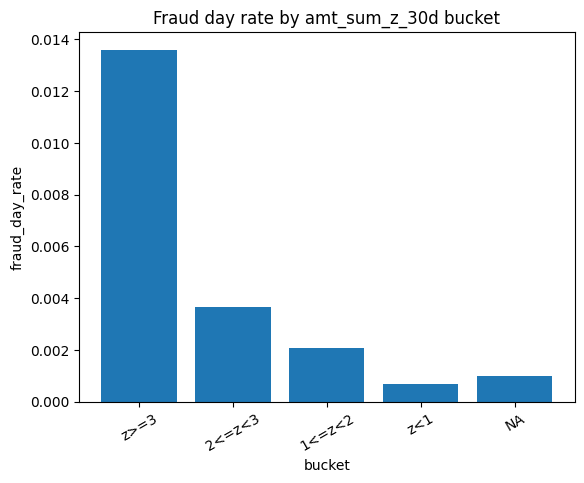

,bucket,n_days,fraud_day_rate
0,z>=3,149346,0.013599
1,2<=z<3,150775,0.003648
2,1<=z<2,407921,0.002089
3,z<1,4674164,0.000682
4,NA,8147,0.000982


In [14]:
import matplotlib.pyplot as plt

df_bucket = con.execute("""
SELECT
  CASE
    WHEN amt_sum_z_30d IS NULL THEN 'NA'
    WHEN amt_sum_z_30d >= 3 THEN 'z>=3'
    WHEN amt_sum_z_30d >= 2 THEN '2<=z<3'
    WHEN amt_sum_z_30d >= 1 THEN '1<=z<2'
    ELSE 'z<1'
  END AS bucket,
  COUNT(*) AS n_days,
  AVG(CAST(fraud_day AS DOUBLE)) AS fraud_day_rate
FROM v_cfinal
GROUP BY 1
ORDER BY
  CASE bucket
    WHEN 'z>=3' THEN 1
    WHEN '2<=z<3' THEN 2
    WHEN '1<=z<2' THEN 3
    WHEN 'z<1' THEN 4
    ELSE 5
  END
""").fetchdf()

plt.figure()
plt.bar(df_bucket["bucket"], df_bucket["fraud_day_rate"])
plt.title("Fraud day rate by amt_sum_z_30d bucket")
plt.xlabel("bucket")
plt.ylabel("fraud_day_rate")
plt.xticks(rotation=30)
plt.show()

df_bucket


**“최근 30일 대비 ‘하루 총 결제금액(amt_sum)’이 갑자기 튄(card-day)일수록, 그날 Fraud가 발생할 확률(fraud_day_rate)이 매우 크게 증가한다.”**

X축: amt_sum_z_30d , 오늘 하루 카드 사용금액 합이 최근 30일 평균 대비 얼마나 비정상적으로 큰가

z = (오늘 amt_sum - 최근 30일 평균 amt_sum) / (최근 30일 표준편차)

Y축: fraud_day_rate , 카드 일자 단위에서 bucket에 속한 날들 중 fraud_day=1, 그날 사기 거래가 존재함의 비율

표에서 z가 클수록 fraud_day_rate가 확실히 커지고, 이에 급증이 클수록 사기 확률이 증가한다.

베이스라인 (전체 평균) 대비 z>=3의 데이터는 약 11배 차이가 나,
평소보다 3a 이상 금액합이 증가하면 그날은 사기 발생 가능성이 평균보다 10배 이상 높다는 뜻입니다.

*여기서 NA는 최근 30일 히스토리가 부족한 초기 구간과 표준편차가 0에 가까워 z꼐산이 불안정한 케이스입니다. 표본은 8,147개(0.15%)로 매우 작고, fraud_day_rate도 극단적으로 높지 않아서 결과에 영향 미치지 않습니다.


# 5-2) 버킷별 fraud_day_rate

z-score 버킷(NA, z<1, 1~2, 2~3, >=3)별 fraud_day_rate

auth_cred_err_cnt >=1 vs 0 의 fraud_day_rate

여기서 나오는 산출물

“고객 로그 기반 인디케이터 근거표 1~2장”

온라인 비중 급증이 위험

거래량/총액 급증이 위험

인증오류 1회 이상이 위험

In [ ]:
from IPython.display import display

def q(sql: str):
    df = con.execute(sql).fetchdf()
    display(df)
    return df

print("1) online_ratio_z_30d 버킷별 fraud_day_rate")
q("""
SELECT
  CASE
    WHEN online_ratio_z_30d IS NULL THEN 'NA'
    WHEN online_ratio_z_30d >= 3 THEN 'z>=3'
    WHEN online_ratio_z_30d >= 2 THEN '2<=z<3'
    WHEN online_ratio_z_30d >= 1 THEN '1<=z<2'
    ELSE 'z<1'
  END AS bucket,
  COUNT(*) AS n_days,
  SUM(fraud_day) AS fraud_days,
  AVG(fraud_day) AS fraud_day_rate
FROM v_cfinal
GROUP BY 1
ORDER BY
  CASE bucket
    WHEN 'z>=3' THEN 1
    WHEN '2<=z<3' THEN 2
    WHEN '1<=z<2' THEN 3
    WHEN 'z<1' THEN 4
    ELSE 5
  END
""")

print("2) tx_cnt_z_30d 버킷별 fraud_day_rate")
q("""
SELECT
  CASE
    WHEN tx_cnt_z_30d IS NULL THEN 'NA'
    WHEN tx_cnt_z_30d >= 3 THEN 'z>=3'
    WHEN tx_cnt_z_30d >= 2 THEN '2<=z<3'
    WHEN tx_cnt_z_30d >= 1 THEN '1<=z<2'
    ELSE 'z<1'
  END AS bucket,
  COUNT(*) AS n_days,
  SUM(fraud_day) AS fraud_days,
  AVG(fraud_day) AS fraud_day_rate
FROM v_cfinal
GROUP BY 1
ORDER BY
  CASE bucket
    WHEN 'z>=3' THEN 1
    WHEN '2<=z<3' THEN 2
    WHEN '1<=z<2' THEN 3
    WHEN 'z<1' THEN 4
    ELSE 5
  END
""")

print("3) amt_sum_z_30d 버킷별 fraud_day_rate")
q("""
SELECT
  CASE
    WHEN amt_sum_z_30d IS NULL THEN 'NA'
    WHEN amt_sum_z_30d >= 3 THEN 'z>=3'
    WHEN amt_sum_z_30d >= 2 THEN '2<=z<3'
    WHEN amt_sum_z_30d >= 1 THEN '1<=z<2'
    ELSE 'z<1'
  END AS bucket,
  COUNT(*) AS n_days,
  SUM(fraud_day) AS fraud_days,
  AVG(fraud_day) AS fraud_day_rate
FROM v_cfinal
GROUP BY 1
ORDER BY
  CASE bucket
    WHEN 'z>=3' THEN 1
    WHEN '2<=z<3' THEN 2
    WHEN '1<=z<2' THEN 3
    WHEN 'z<1' THEN 4
    ELSE 5
  END
""")

print("4) auth_cred_err_cnt (0 vs 1+) 버킷별 fraud_day_rate")
q("""
SELECT
  CASE WHEN auth_cred_err_cnt >= 1 THEN '>=1' ELSE '0' END AS bucket,
  COUNT(*) AS n_days,
  SUM(fraud_day) AS fraud_days,
  AVG(fraud_day) AS fraud_day_rate
FROM v_cfinal
GROUP BY 1
ORDER BY CASE bucket WHEN '>=1' THEN 1 ELSE 2 END
""")

1) online_ratio_z_30d 버킷별 fraud_day_rate


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,bucket,n_days,fraud_days,fraud_day_rate
0,z>=3,154618,1365.0,0.008828
1,2<=z<3,117783,1019.0,0.008652
2,1<=z<2,243476,990.0,0.004066
3,z<1,4273912,2736.0,0.000640
4,NA,600564,518.0,0.000863


2) tx_cnt_z_30d 버킷별 fraud_day_rate


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,bucket,n_days,fraud_days,fraud_day_rate
0,z>=3,141413,1439.0,0.010176
1,2<=z<3,201167,781.0,0.003882
2,1<=z<2,522660,1275.0,0.002439
3,z<1,4501688,3096.0,0.000688
4,NA,23425,37.0,0.001580


3) amt_sum_z_30d 버킷별 fraud_day_rate


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,bucket,n_days,fraud_days,fraud_day_rate
0,z>=3,149346,2031.0,0.013599
1,2<=z<3,150775,550.0,0.003648
2,1<=z<2,407921,852.0,0.002089
3,z<1,4674164,3187.0,0.000682
4,NA,8147,8.0,0.000982


4) auth_cred_err_cnt (0 vs 1+) 버킷별 fraud_day_rate


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,bucket,n_days,fraud_days,fraud_day_rate
0,>=1,34762,381.0,0.010960
1,0,5355591,6247.0,0.001166


,bucket,n_days,fraud_days,fraud_day_rate
0,>=1,34762,381.0,0.010960
1,0,5355591,6247.0,0.001166


z-score 기반 “이상징후”가 강력한 사전 신호로 확인됨

스크린샷에 나온 버킷 결과를 “경고 시스템 관점(커버리지 vs 적중률)”으로 해석하면:

A. amt_sum_z_30d (30일 금액합 z-score)

z>=3:

전체 day의 2.77%(149,346/5,390,353)만 차지하지만

fraud_day의 30.6%(2031/6628)를 포함

fraud_day_rate 1.3599% (베이스 0.123% 대비 약 11배 수준)

→ “최근 30일 대비 금액합이 급증”은 경고지표로 매우 우수합니다.

B. tx_cnt_z_30d (30일 거래횟수 z-score)

z>=3:

day의 **2.62%**인데

fraud_day의 **21.7%**를 포함

fraud_day_rate 1.0176%

→ “거래횟수 급증”도 강력.

C. online_ratio_z_30d (온라인 비율 z-score)

z>=3:

day의 **2.87%**인데

fraud_day의 **20.6%**를 포함

fraud_day_rate 0.8828%

→ “갑자기 온라인 비중이 높아짐”도 강력.

D. auth_cred_err_cnt (인증 오류 카운트) 0 vs 1+

>=1:

day의 0.645%(34,762/5,390,353)만 차지하지만

fraud_day_rate가 1.096%

0인 그룹(0.1166%) 대비 약 9.4배

→ “인증오류가 발생한 day”는 고위험 day로 보기 적절.